## K-means clustering

In [1]:
# Import Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Load the dataset
df = pd.read_csv('../DMW_DataSets/Online Retail.csv',encoding='latin-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,88000,01-12-2010 08:26,700.00,17850.0,United Kingdom
1,536365,71053,REGENCY CAKESTAND 3 TIER,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
# Preprocessing the data
df.dropna(subset=['CustomerID','Quantity','UnitPrice'],inplace=True)
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
df['TotalSpend'] = df['Quantity'] * df['UnitPrice']

In [4]:
# Transforming the data
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],format='mixed')
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
df['Recency'] = (snapshot_date - df['InvoiceDate']).dt.days

customer_data = df.groupby('CustomerID').agg(
    TotalSpend = ('TotalSpend','sum'),
    Frequency = ('InvoiceNo','nunique'),
    Recency = ('Recency','min')
).reset_index()

In [5]:
# Standardize the data
scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data[['TotalSpend','Frequency','Recency']])

In [6]:
inertia = []
K_range = range(1,11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_data_scaled)
    inertia.append(kmeans.inertia_)

C:\Users\Yogesh Tatavdekar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Yogesh Tatavdekar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Yogesh Tatavdekar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Yogesh Tatavdekar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users

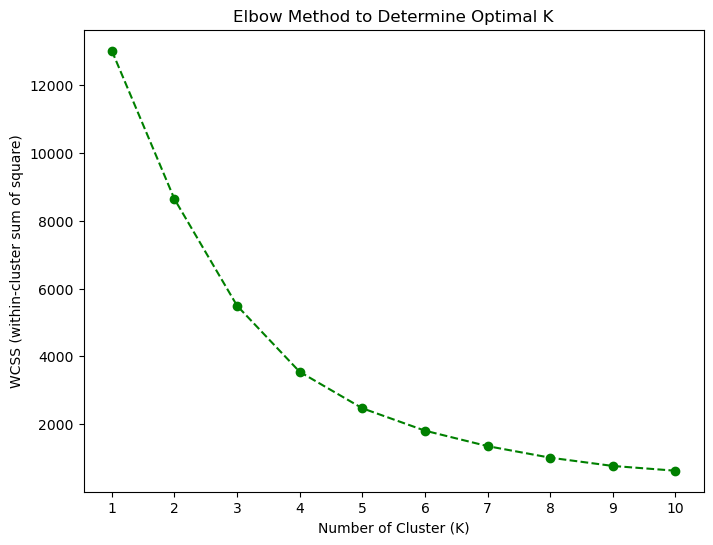

In [7]:
plt.figure(figsize=(8,6))
plt.plot(K_range, inertia, marker='o', linestyle='--', color='g')
plt.xlabel('Number of Cluster (K)')
plt.ylabel('WCSS (within-cluster sum of square)')
plt.title('Elbow Method to Determine Optimal K')
plt.xticks(K_range)
plt.show()

In [13]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(customer_data_scaled)

C:\Users\Yogesh Tatavdekar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


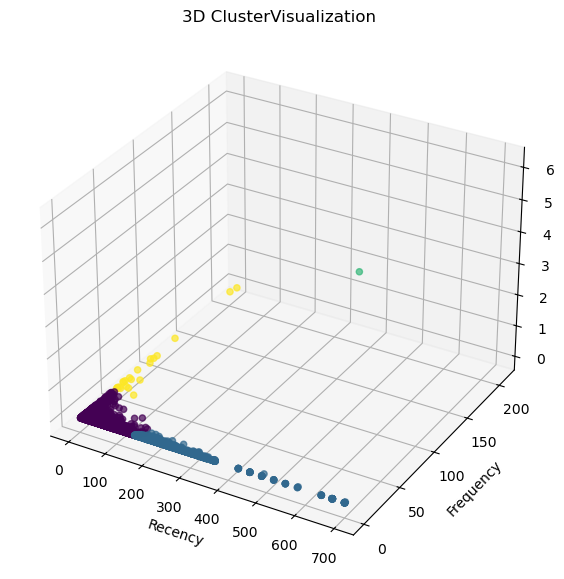

In [16]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111,projection='3d')

scatter = ax.scatter(customer_data
                    ['Recency'], customer_data['Frequency'], customer_data['TotalSpend'], c=customer_data['Cluster'],
                     cmap='viridis',alpha=0.7)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D ClusterVisualization')
plt.show()

In [18]:
sil_score = silhouette_score(customer_data_scaled, kmeans.labels_)
print(f"Silhouette score:{sil_score:.3f}")

Silhouette score:0.567


In [19]:
cluster_size = customer_data['Cluster'].value_counts()
print("Number of customers per cluster:\n",cluster_size)

Number of customers per cluster:
 Cluster
0    3141
1    1174
3      22
2       1
Name: count, dtype: int64


In [21]:
centers_transformed = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centroids = customer_data.groupby('Cluster').mean()
print(centers_transformed)
print(cluster_centroids)

[[2.08581103e+03 4.77682267e+00 4.88882521e+01]
 [5.66497718e+02 1.52470187e+00 2.61866269e+02]
 [6.16053759e+07 3.40000000e+01 6.67000000e+02]
 [7.67916327e+04 7.74545455e+01 9.77272727e+00]]
           CustomerID    TotalSpend  Frequency     Recency
Cluster                                                   
0        15298.318052  2.085811e+03   4.776823   48.888252
1        15307.695060  5.664977e+02   1.524702  261.866269
2        17850.000000  6.160538e+07  34.000000  667.000000
3        15094.045455  7.679163e+04  77.454545    9.772727


In [23]:
cluster_std = customer_data.groupby('Cluster').std()
print(cluster_std)

          CustomerID    TotalSpend  Frequency     Recency
Cluster                                                  
0        1716.429663   5494.909020   5.121907   39.193964
1        1737.839877   2321.001323   0.973119  106.592707
2                NaN           NaN        NaN         NaN
3        1642.439750  76790.015917  46.368839   12.872754


In [24]:
cluster_percentage = (cluster_size / cluster_size.sum())*100
print(cluster_percentage)

Cluster
0    72.406639
1    27.063163
3     0.507146
2     0.023052
Name: count, dtype: float64
